### Spatial Query on Taxi Trips

In [ ]:
place = 'JFK'

gdf = ox.gdf_from_place(place)
jfkairport = gdf.geometry

n=1
while n <= 11000000:
    data = pd.read_csv('yellow_tripdata_2016-06.csv', skiprows=n, nrows=1000000, names=cols)

    data = data[data.pickup_longitude != 0]
    data = data[data.dropoff_longitude != 0]
    data = data[data.pickup_latitude != 0]
    data = data[data.dropoff_latitude != 0]
    data= data[data.dropoff_latitude != data.pickup_latitude]
    
    pickairportdata = data.copy()
    dropairportdata = data.copy()

    data[['pickup_longitude','pickup_latitude']].astype(float)

    pickup_point = [Point(xy) for xy in zip(data.pickup_longitude,data.pickup_latitude)]
    picktaxirides = gpd.GeoDataFrame(pickairportdata, geometry=pickup_point)
    
    dropoff_point = [Point(xy) for xy in zip(data.dropoff_longitude,data.dropoff_latitude)]
    droptaxirides = gpd.GeoDataFrame(dropairportdata, geometry=dropoff_point)
    
    data['airportpick'] = picktaxirides['geometry'].map(lambda x: True if jfkairport.contains(x).any()==True else False)
    data['airportdrop'] = droptaxirides['geometry'].map(lambda x: True if jfkairport.contains(x).any()==True else False)
    
    data= data[((data.airportpick == True ) | (data.airportdrop == True))]
    
    with open('processed_data.csv', 'a') as f:
        data.to_csv(f, header=False)
    
    print ('finish')
    
    n = n +1000000

### PostGIS and Geojson creation

In [47]:
import pandas as pd
import numpy as np
import json
from shapely.geometry import MultiPolygon, Polygon, Point

In [2]:
import psycopg2
conn = psycopg2.connect("dbname=newyork user=chris host=localhost password=12345")
cur = conn.cursor()

# http://postgis.net/docs/manual-1.3/ch06.html

cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")   
cur.fetchall()

[('newyork2016',),
 ('geography_columns',),
 ('geometry_columns',),
 ('spatial_ref_sys',),
 ('raster_columns',),
 ('raster_overviews',),
 ('taxi_zones_latlong',)]

In [61]:
# Query to group taxi trips to taxi zones
cur.execute("SELECT NY.*, TZ.zone " +\
            "from newyork2016 NY, taxi_zones_latlong TZ " +\
            "where NY.airportpick = True and NY.airportdrop = False and " +\
            "ST_contains(TZ.geom, NY.pickup_point) is true;")  
d= cur.fetchall()

cur.execute("SELECT * FROM information_schema.columns WHERE table_schema = 'public' AND table_name   = 'newyork2016'")
cols= pd.DataFrame(cur.fetchall())

In [6]:
# function to split time into hour
def hr_func(ts):
    return ts.hour

In [51]:
# function to turn dataframe into linestring coordinates and origin destination Point coordinates
def df_to_geojson_line(df, properties, olat='pickup_latitude', olon='pickup_longitude', 
                       dlat='dropoff_latitude', dlon='dropoff_longitude'):
    geojson = {'type':'FeatureCollection',  'features':[]}
    for _, row in df.iterrows():
        feature = {"type":"Feature",
                   "geometry":{"type":"LineString",
                               'coordinates':[[row[olon],row[olat]],[row[dlon],row[dlat]]]},
                   'origin': {'type':'Point',
                               'coordinates':[row[olon],row[olat]]},
                   'destination': {'type':'Point',
                               'coordinates':[row[dlon],row[dlat]]},
                   'properties': {}
                  }
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

In [64]:
# processing data to be placed into geojson

cols = np.append(cols[3].values,['zone'])

data= pd.DataFrame(d, columns= cols)

data['pickup_hour']=data.origin_datetime.apply(hr_func)
data['dropoff_hour']=data.destination_datetime.apply(hr_func)

data.origin_datetime= data.origin_datetime.astype('string')
data.destination_datetime= data.destination_datetime.astype('string')

# data.pickup_point = [Point(xy) for xy in zip(data.pickup_longitude,data.pickup_latitude)]
# data.dropoff_point =[Point(xy) for xy in zip(data.dropoff_longitude,data.dropoff_latitude)]
data.drop(['pickup_point','dropoff_point'])

d= data.head(20000)
geojson_line= df_to_geojson_line(d, cols)

AttributeError: 'str' object has no attribute 'values'

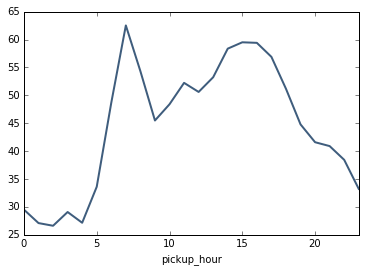

In [195]:
# plot of travel time by hour
(data.groupby('pickup_hour').travel_time.mean()/60).plot(color="#3F5D7D", linewidth=2.0)

In [152]:
cols = d2.columns.values
geojson_line= df_to_geojson_line(d2, cols)

In [163]:
# create js file with processed geojson data

with open('pickups_small_2.js', 'w') as outfile:
    outfile.write('var dataset =')
    json.dump(geojson_line, outfile)

### Create GeoPandas Plots

In [10]:
import geopandas as gpd

In [69]:
# They were in projection EPSG:2263 / NAD83. Converted them to lat long
boros = gpd.GeoDataFrame.from_file('taxi_zones/taxi_zones_latlong.shp')
#boros.set_index('zone', inplace=False)


In [79]:
data.groupby('zone').index.count()

zone
Allerton/Pelham Gardens                  90
Alphabet City                           745
Arden Heights                             5
Arrochar/Fort Wadsworth                  28
Astoria                                2068
Astoria Park                              6
Auburndale                              168
Baisley Park                           2625
Bath Beach                              164
Battery Park                             24
Battery Park City                      1660
Bay Ridge                              1054
Bay Terrace/Fort Totten                 260
Bayside                                 436
Bedford                                1508
Bedford Park                            129
Bellerose                               224
Belmont                                  89
Bensonhurst East                        269
Bensonhurst West                        327
Bloomfield/Emerson Hill                  58
Bloomingdale                            573
Boerum Hill                

In [70]:
boros= boros.merge(data.groupby('zone').tip_amount.mean().reset_index(),on='zone')
boros= boros.merge(data.groupby('zone').passenger_count.mean().reset_index(),on='zone')

In [80]:
boros= boros.merge(data.groupby('zone').index.count().reset_index(),on='zone')

In [97]:
temp = data.groupby('zone').travel_time.mean().reset_index()
temp.travel_time= temp.travel_time/60
boros= boros.merge(temp,on='zone')

In [139]:
d2= d.merge(boros[['OBJECTID','zone']], on='zone')

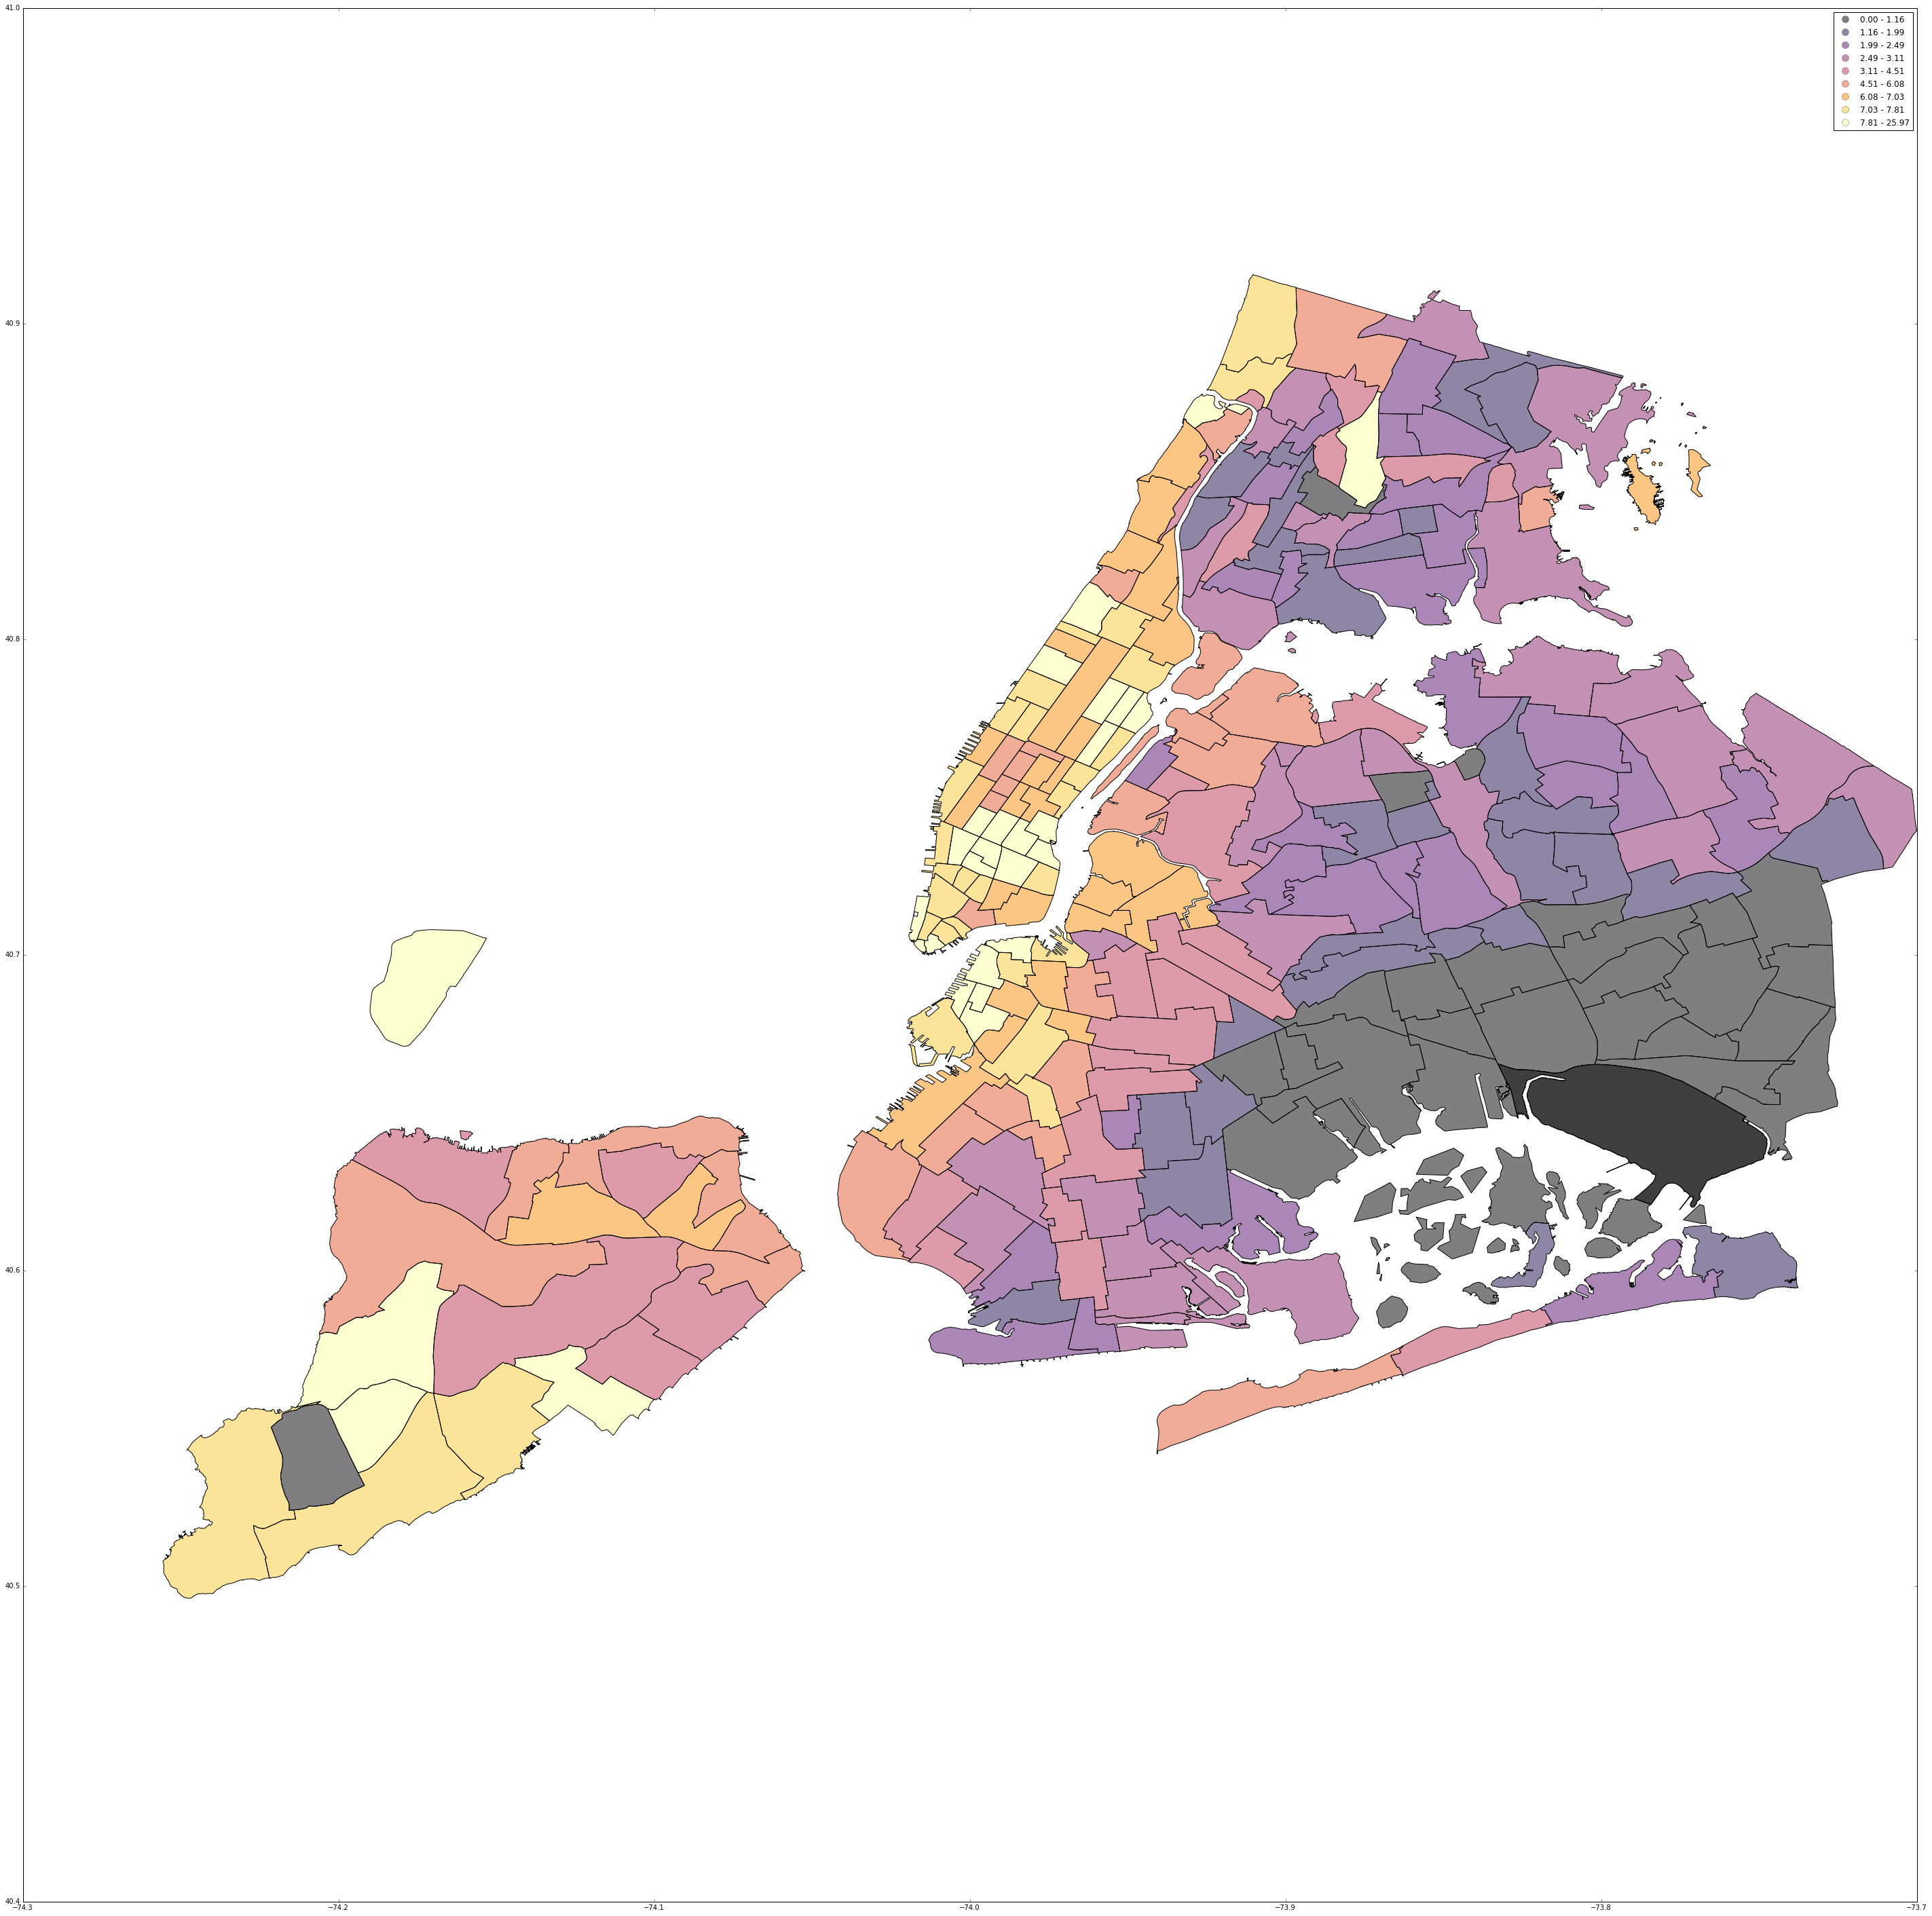

In [173]:
 import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize= (50,50))
ax.set_aspect('equal')

boros.plot(ax=ax, column='tip_amount',legend=True,  scheme= 'QUANTILES', k = 9, cmap= 'inferno', figsize= (50,50))

boros[boros['zone']=='JFK Airport'].plot(ax=ax,figsize= (50,50), color='Black')


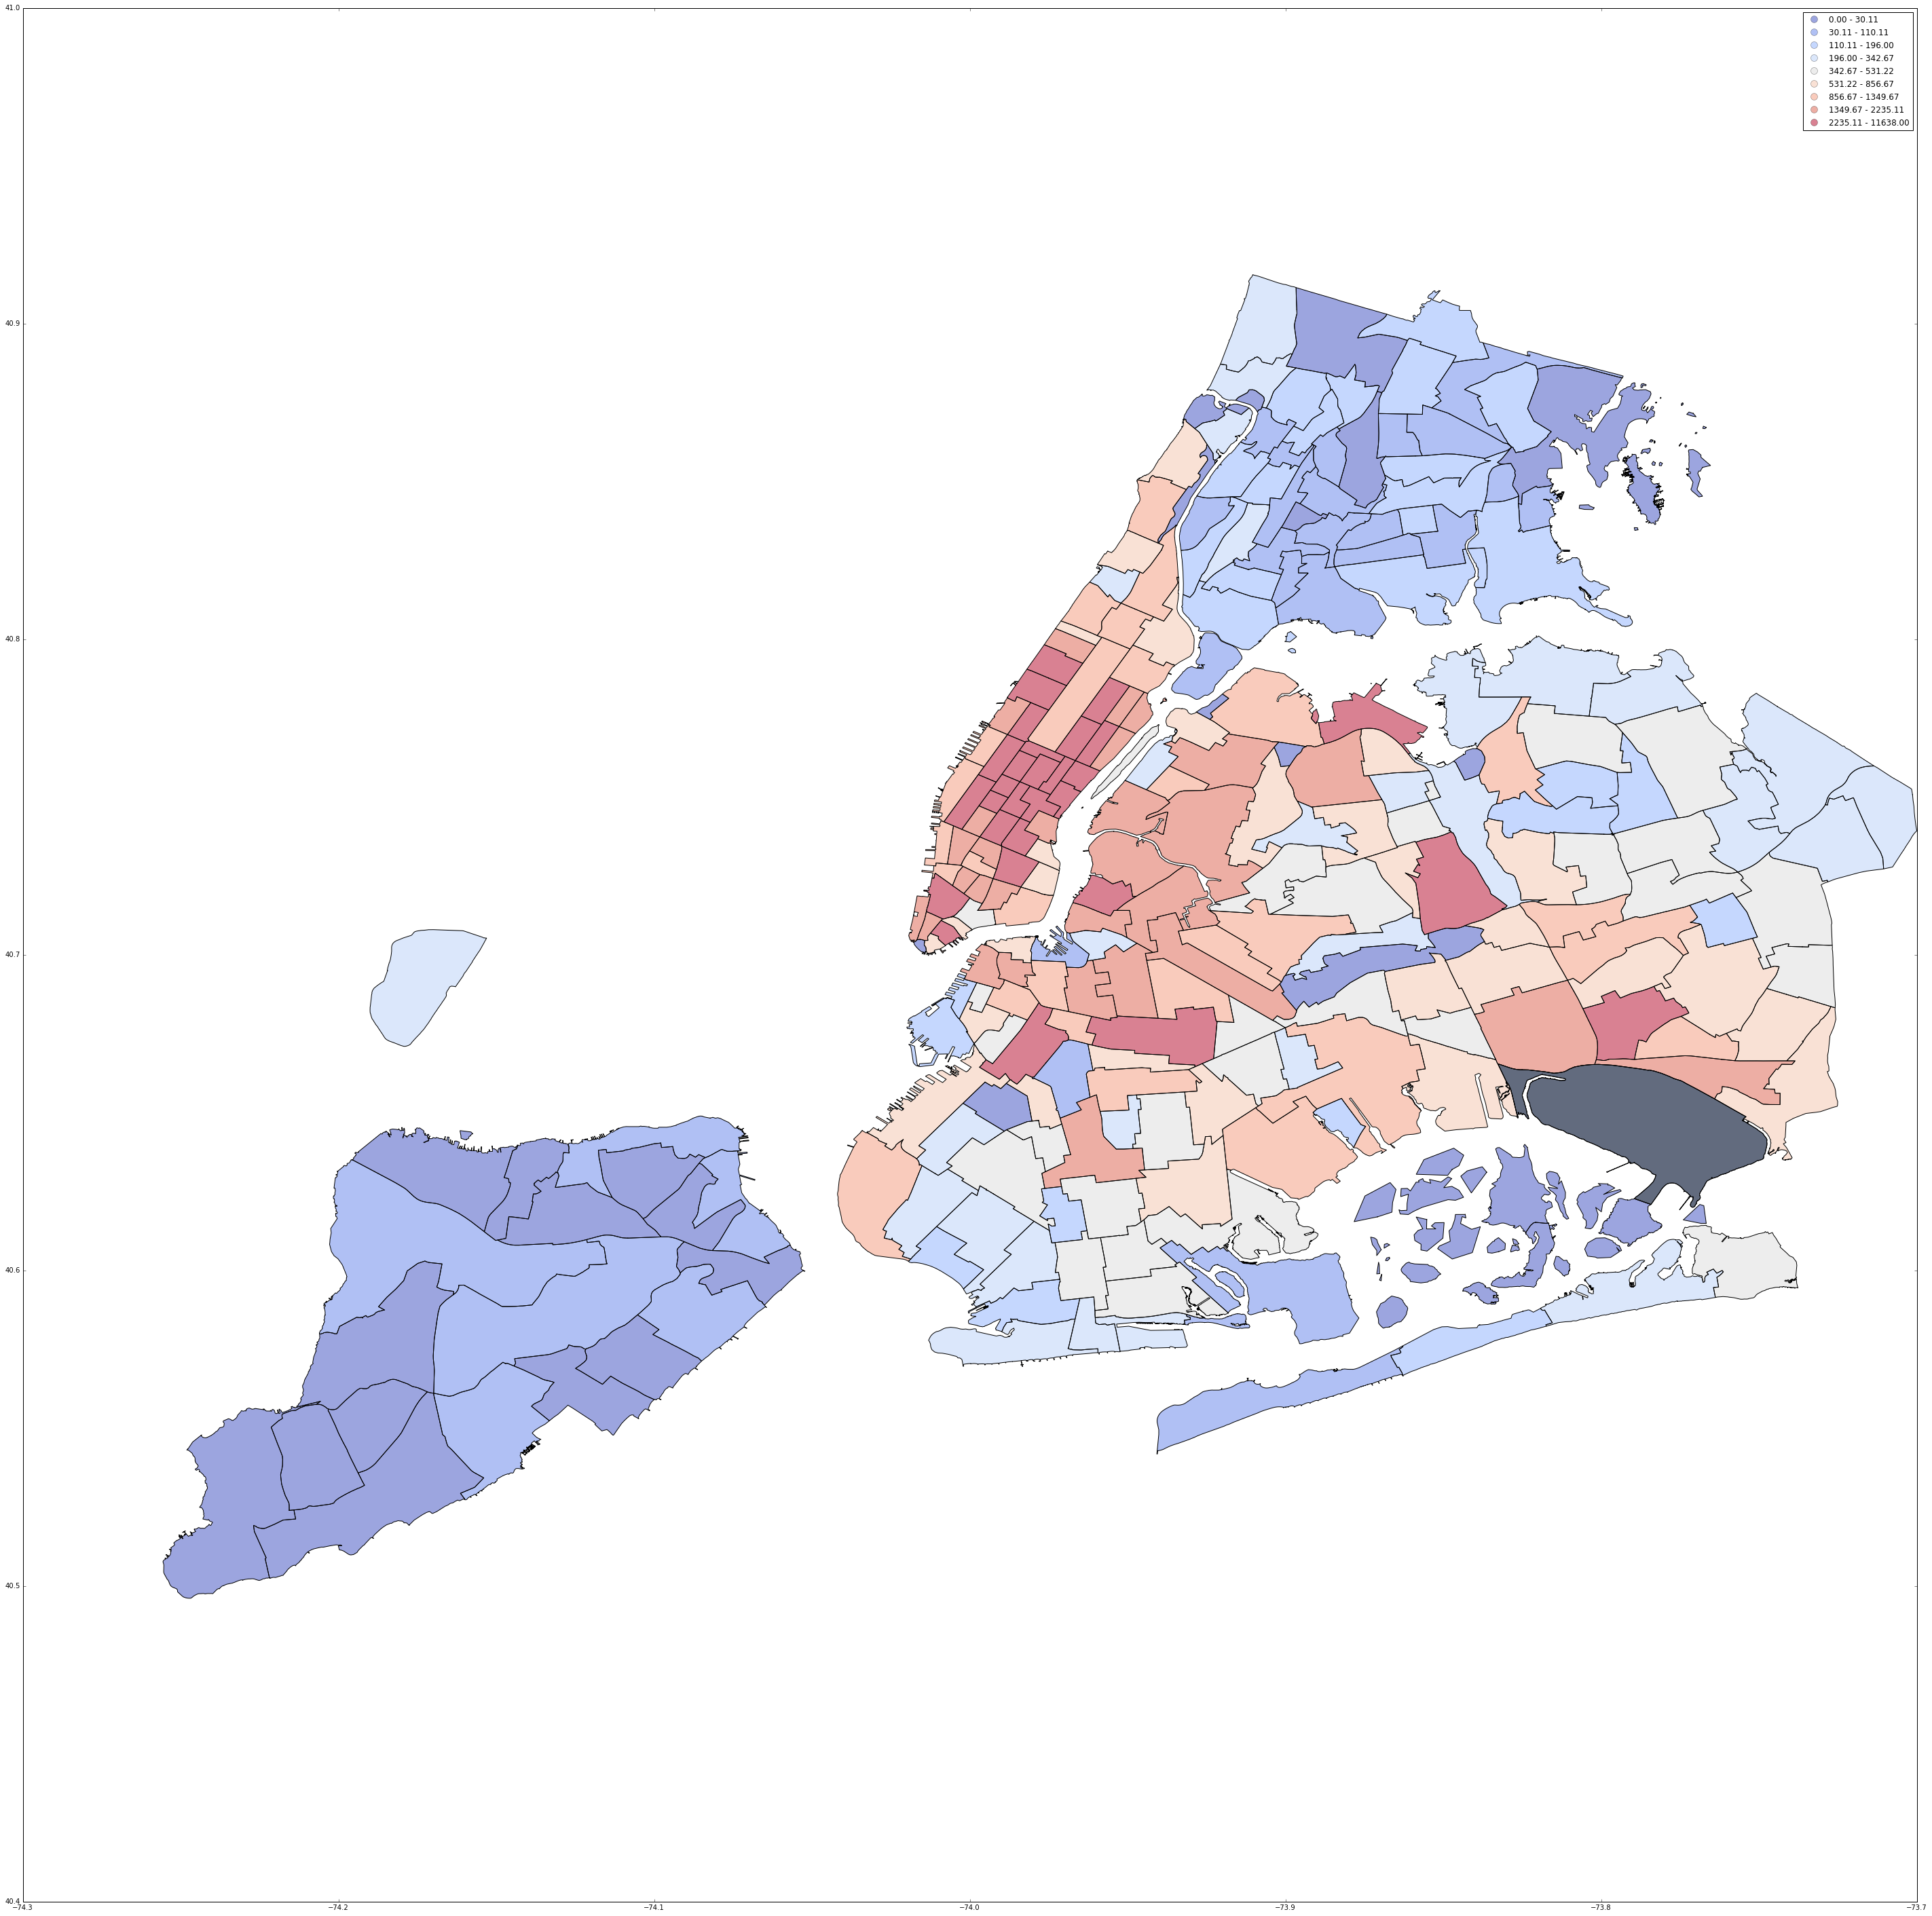

In [199]:
fig, ax = plt.subplots(figsize= (50,50))
ax.set_aspect('equal')

boros.plot(ax=ax,column='index', scheme= 'QUANTILES', legend=True, k = 9, cmap= 'coolwarm', figsize= (50,50))
boros[boros['zone']=='JFK Airport'].plot(ax=ax,figsize= (50,50), color='Black')

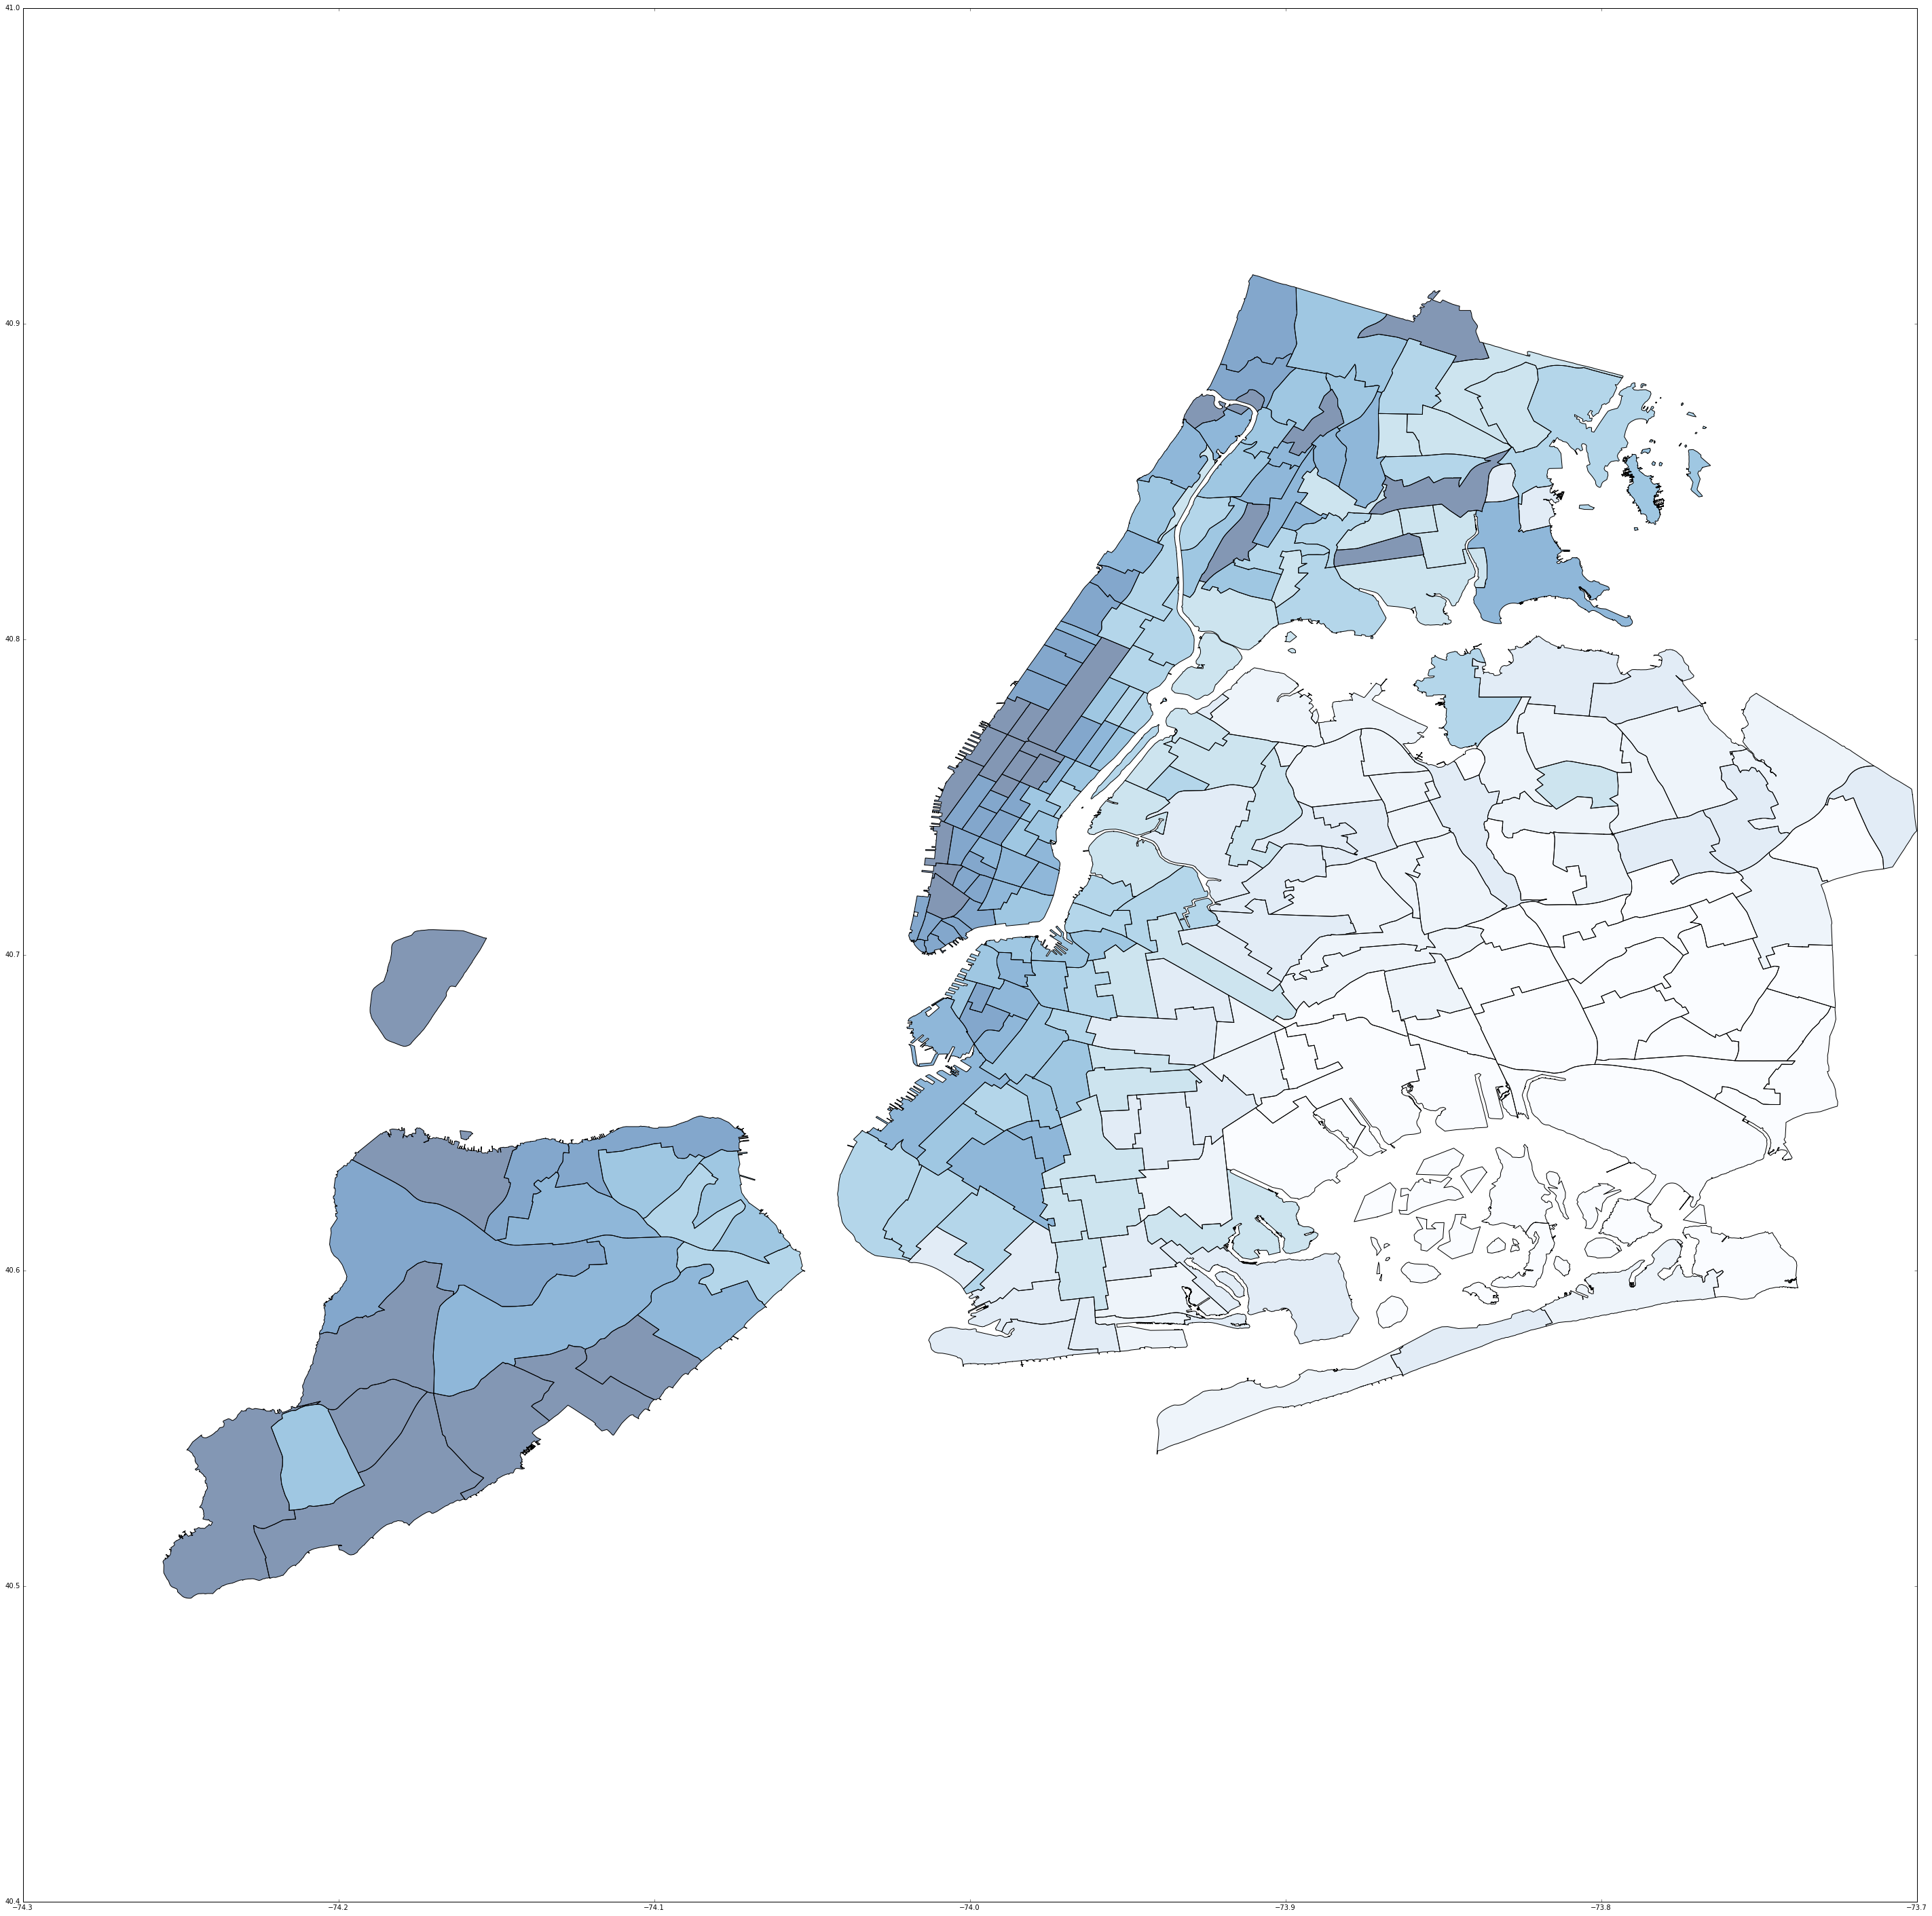

In [99]:
boros.plot(column='travel_time', scheme= 'QUANTILES', k = 9, cmap= 'Blues', figsize= (50,50))

### Clustering data

In [200]:
def dbscan(X, e):
    t_db = time.time()
    db = DBSCAN(eps = e, min_samples=100).fit(X)
    t_fin_db = time.time() - t_db
    
    db_labels = db.labels_
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    db_labels_unique = np.unique(db_labels)

    print (db_labels_unique.size)
    print ("labels:\n %s, \n  unique labels:\n %s" % (db_labels, db_labels_unique))
    
    #Plot clusters
    fig = plt.figure(figsize=(6, 6))
    colors = plt.cm.Spectral(np.linspace(0, 1, len(db_labels_unique)))
    base = boros.plot(color='white')

    for k, col in zip(db_labels_unique, colors):
        if k == -1:
        # Black used for noise.
            col = 'k'
        class_member_mask = (db_labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14, axes = base)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6, axes = base)
    

    plt.show()



In [201]:
datapick = data[d]
X = datapick.values[:, 10:12]

dbscan(X, 0.008)

NameError: name 'datapick' is not defined

### Gaussian Process

In [ ]:
#Create a grid in the zones. To that grid add an specific time we want to test

geogrid = []
def make_grid(bounding_box, ncell):
    xmax, xmin, ymax, ymin = bounding_box
    xgrid = np.linspace(xmin, xmax, ncell)
    ygrid = np.linspace(ymin, ymax, ncell)
    mX, mY = np.meshgrid(xgrid, ygrid)
    ngridX = mX.reshape(ncell*ncell, 1);
    ngridY = mY.reshape(ncell*ncell, 1);
    return np.concatenate((ngridX, ngridY), axis=1)
bounding_box = [40.4, 41, -73.7, -74.3]
grid = make_grid(bounding_box, 50)
##convert lat and lon into a point and create a geotable
grid_points = [Point(xy) for xy in zip(grid[:,1],grid[:,0])]
geogrid = gpd.GeoDataFrame(geometry=grid_points)
geogrid['inside'] = geogrid['geometry'].map(lambda x: True if bigboros.contains(x).any()==True else False)
geogrid = geogrid[geogrid.inside == True]

lon = []
lat = []
for index, row in geogrid.iterrows(): 

    lon.append(row.geometry.centroid.x) 
    lat.append(row.geometry.centroid.y)

geogrid['lon'] = np.array(lon)
geogrid['lat'] = np.array(lat)
n = len(geogrid)
geogrid['hour'] = np.random.random_integers(0, 23, n)
geogrid['hour_6to8'] = np.random.random_integers(6, 8, n)
geogrid['hour_14to17'] = np.random.random_integers(14, 17, n)


In [ ]:
import sklearn.metrics as sk
from scipy import spatial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

Xminor = datapick.iloc[:10000,:]

Xx = Xminor[['dropoff_longitude','dropoff_latitude','pickup_hour']]
yy = Xminor[['travel_time']]

# Instanciate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(Xx, yy)


x_test = np.array(geogrid[['lon','lat','hour_14to17']])

sigmma = 0.5
# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x_test, return_std=True)